In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
#import torchviz
import time
import copy

import matplotlib.pyplot as plt

import ase.io

from utils.dataset import AtomisticDataset, create_dataloader
from utils.soap import PowerSpectrum
from utils.alchemical import AlchemicalCombine
from utils.linear import LinearModel

torch.set_default_dtype(torch.float64)

In [3]:
torch.cuda.is_available()

False

In [4]:
n_test = 100
n_train = 100

frames = ase.io.read("data/xyz/data.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor([frame.info["energy"] for frame in train_frames]).reshape(-1, 1)
test_energies = torch.tensor([frame.info["energy"] for frame in test_frames]).reshape(-1, 1)

train_forces = [torch.tensor(frame.arrays["forces"]) for frame in train_frames]
test_forces = [torch.tensor(frame.arrays["forces"]) for frame in test_frames]

print(f"using {n_train} training frames")

using 100 training frames


In [5]:
global_species = set()
for frame in frames:
    global_species.update(frame.numbers)

global_species = list(map(lambda u: int(u), global_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": global_species,
# }

HYPERS_SMALL = {
    "cutoff": 5.0,
    "max_angular": 3,
    "max_radial": 4,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto": {}},
    "gradients": False,
}

# Optimization loop, energies only

In [6]:
# device = "cuda"
device = "cpu"

train_dataset = AtomisticDataset(train_frames, HYPERS_SMALL, train_energies)
test_dataset = AtomisticDataset(test_frames, HYPERS_SMALL, test_energies)

In [16]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    device=device,
)

In [17]:
def loss_optimizer(predicted, actual, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_optimizer_forces(predicted, actual, predicted_f, actual_f, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    loss += torch.linalg.norm(predicted_f.flatten() - actual_f.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted.flatten() - actual.flatten()))

In [18]:
class MixedSpeciesLinearModel(torch.nn.Module):
    def __init__(self, 
        species, 
        n_pseudo_species, 
        regularizer,
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.alchemical = AlchemicalCombine(species, n_pseudo_species)
        self.power_spectrum = PowerSpectrum()
        self.model = LinearModel(
            normalize=True, 
            regularizer=regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )

        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, spherical_expansion, forward_forces=False):
        # TODO: remove gradients if forward_forces is false
        combined = self.alchemical(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        energies, forces = self.model(power_spectrum, with_forces=forward_forces)
        return energies, forces

    def initialize_parameters(self, spherical_expansion, energies, forces=None):
        combined = self.alchemical(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        self.model.initialize_parameters(power_spectrum, energies, forces)
        

In [19]:
N_PSEUDO_SPECIES = 4
TORCH_REGULARIZER = 1e-2
LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

mixed_species_model = MixedSpeciesLinearModel(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True,
    random_initial_weights=True,
)

In [20]:
mixed_species_model.to(device=device)

# initialize the model
with torch.no_grad():
    for spherical_expansions, energies, _ in train_dataloader_no_batch:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        mixed_species_model.initialize_parameters(spherical_expansions, energies)

if mixed_species_model.optimizable_weights:
    torch_loss_regularizer = TORCH_REGULARIZER
else:
    torch_loss_regularizer = 0
    # we can not use batches if we are training with linear algebra, we need to
    # have all training frames available
    assert train_dataloader.batch_size >= len(train_frames)

In [21]:
lr = 0.1
# optimizer = torch.optim.AdamW(
#     mixed_species_model.parameters(), 
#     lr=lr, weight_decay=0.0
# )

optimizer = torch.optim.LBFGS(
    mixed_species_model.parameters(), 
    lr=lr,
)

all_losses = []


filename = f"{mixed_species_model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if mixed_species_model.optimizable_weights:
    filename += "-opt-weights"

if mixed_species_model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [23]:
for epoch in range(5):
    epoch_start = time.time()

    # if UPDATE_SUPPORT_POINTS:
    #     # to update the support points, we need to have all training data at
    #     # once in memory
    #     for spherical_expansions, species, slices, _ in train_dataloader_no_batch:
    #         assert len(slices) == len(train_frames)
    #         # use `select_again=True` to re-select the same number of support
    #         # points. this might make convergence slower, but maybe able to
    #         # reach a lower final loss?
    #         #
    #         # with `select_again=False`, the environments selected in the first
    #         # fit above are used as support points
    #         mixed_species_model.update_support_points(
    #             spherical_expansions, species, slices, select_again=False
    #         )

    for spherical_expansions, energies, _ in train_dataloader:
        def single_step():
            optimizer.zero_grad()
           
            if not mixed_species_model.optimizable_weights:
                mixed_species_model.initialize_parameters(spherical_expansions, energies)
                
            predicted, _ = mixed_species_model(spherical_expansions)

            loss = loss_optimizer(
                predicted, 
                energies, 
                torch_loss_regularizer, 
                mixed_species_model.model.weights
            )
            loss.backward(retain_graph=True)

            return loss
            
        loss = optimizer.step(single_step)
        all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            reference = []
            for spherical_expansions, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = mixed_species_model(spherical_expansions)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted.cpu(), reference)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss.item():.4}, test mae={mae:.4}")
        
    n_epochs_total += 1

epoch 0 took 2.776s, optimizer loss=7.94e+06, test mae=74.04
epoch 1 took 2.749s, optimizer loss=6.548e+05, test mae=41.72
epoch 2 took 2.751s, optimizer loss=6.78e+04, test mae=26.46
epoch 3 took 2.757s, optimizer loss=1.072e+04, test mae=24.2
epoch 4 took 2.814s, optimizer loss=3.357e+03, test mae=23.8


# Predicting forces with forward propagation

In [24]:
HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
HYPERS_GRAD["gradients"] = True

test_dataset_grad = AtomisticDataset(test_frames, HYPERS_GRAD, test_energies, test_forces)

test_dataloader_grad_no_batch = create_dataloader(
    test_dataset_grad,
    batch_size=len(test_dataset_grad),
    shuffle=False,
    device=device,
)

In [25]:
with torch.no_grad():
    for spherical_expansions, energies, forces in test_dataloader_grad_no_batch:
        predicted_e, predicted_f = mixed_species_model(spherical_expansions, forward_forces=True)

Text(0, 0.5, 'predicted')

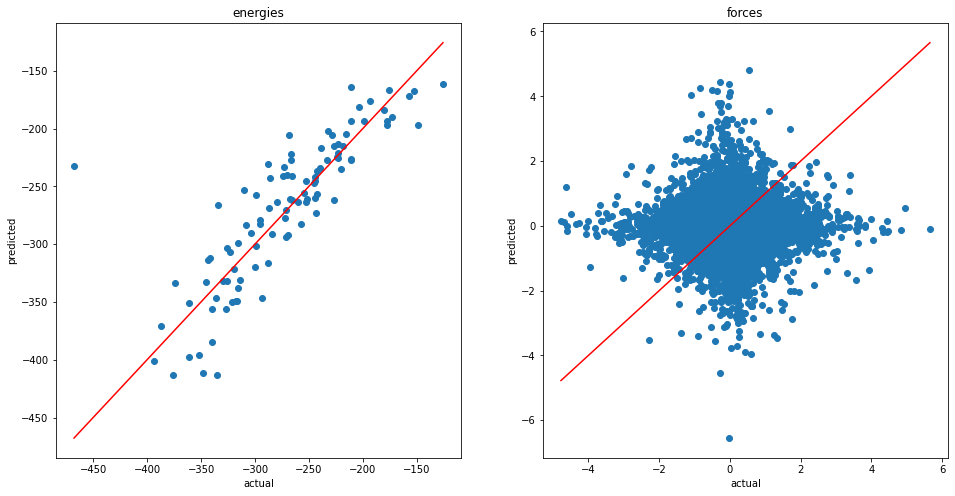

In [26]:
fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

ax_e.scatter(energies, predicted_e.detach())
x = (torch.min(energies.flatten()), torch.max(energies.flatten()))
ax_e.plot(x, x, color="red")
ax_e.set_title("energies")
ax_e.set_xlabel("actual")
ax_e.set_ylabel("predicted")

ax_f.scatter(forces, predicted_f.detach())
x = (torch.min(forces.flatten()), torch.max(forces.flatten()))
ax_f.plot(x, x, color="red")
ax_f.set_title("forces")
ax_f.set_xlabel("actual")
ax_f.set_ylabel("predicted")